In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

## EDA


In [2]:
# Fetch data from Yahoo Finance
df = yf.download(tickers='NVDA', start='2020-01-01')
df_xlk = yf.download(tickers='XLK', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'NVDA vs XLK Price')

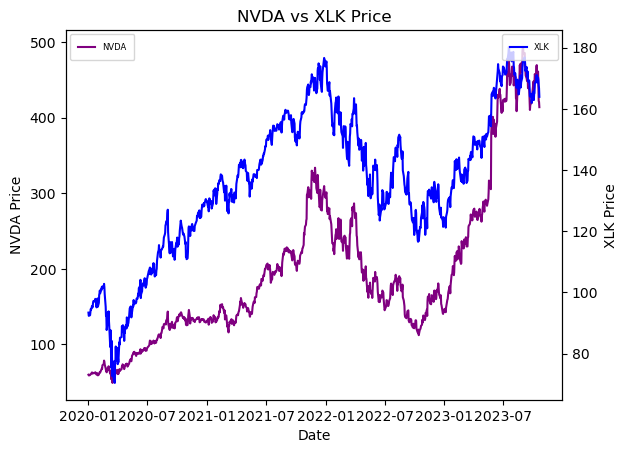

In [3]:
# Finding correlation between NVDA and XLK ETF
fig, ax = plt.subplots()
ax.plot(df['Close'], color='purple', label='NVDA')
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Price')
ax.legend(loc='upper left', borderpad=1, fontsize=6)

ax2 = ax.twinx()
ax2.plot(df_xlk['Close'], color='blue', label='XLK')
ax2.set_ylabel('XLK Price')
ax2.legend(loc='upper right', borderpad=1, fontsize=6)
plt.title('NVDA vs XLK Price')

## Prepare Data

### Log Returns 
$\ln(\frac{Current Price}{Original Price})$

Log returns measure the percentage change in value over time. This allows us to have a good gauge of the general direction of price.

### Index Funds
Index funds are indicators of the general performance of the sector. For this case, the SMA20 of [SPDR Technology Sector Fund (XLK)](https://finance.yahoo.com/quote/XLK?p=XLK) is used as a gauge for the performance of the tech industry as a whole.

In [4]:
# GLOBAL VARS
NUM_VARS = 7
TIMESTEPS = 10
DAYS_TO_PRED = 15

In [5]:
# Calculate SMA20 for XLK
df['xlk_SMA20'] = df_xlk['Adj Close'].rolling(20).mean()

# Calculate percentage changes
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())

# Drop Close column
df.dropna(inplace=True)
#df.reset_index(inplace=True)
df.drop(['Close'], axis=1, inplace=True)

# Assign a final df for accessing later
output_df = df[TIMESTEPS:]


In [6]:
# Define function to split data
def split(data):
    # DAYS_TO_PRED rows will be removed for test data, remaining split 80 20
    test_val_len = len(data) - DAYS_TO_PRED
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = data[: l_80], data[l_80 : test_val_len], data[test_val_len :]
    return train_data, val_data, test_data

In [7]:
# Define function to create dataset with timesteps
def create_dataset(dataset, timesteps):
    x = []
    y = []
    for i in range(len(dataset) - timesteps):
        add_x = dataset[i : i + timesteps] # Slice from 0 - timesteps
        add_y = dataset[i + timesteps]

        # Extract vars
        add_x = [lst for lst in add_x]

        x.append(add_x)
        y.append(add_y)
    return np.array(x), np.array(y)

In [8]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Create datasets
X_full, y_full = create_dataset(df, TIMESTEPS)

# Split data
X_train, X_val, X_test = split(X_full)
y_train, y_val, y_test = split(y_full)

# Shape should be (samples, timesteps, features)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((731, 10, 7), (731, 7), (183, 10, 7), (183, 7), (15, 10, 7), (15, 7))

In [9]:
X_train[1]

array([[0.02425713, 0.01916477, 0.03041674, 0.0223592 , 0.18847228,
        0.16629563, 0.39110516],
       [0.01968438, 0.01730993, 0.03081052, 0.02454399, 0.10904361,
        0.16834175, 0.52204987],
       [0.02539617, 0.02108069, 0.03563152, 0.02835339, 0.12009458,
        0.17149999, 0.5493935 ],
       [0.02869165, 0.02357971, 0.03753854, 0.03038694, 0.07630286,
        0.17495673, 0.51783495],
       [0.02877459, 0.0246071 , 0.03836548, 0.03234207, 0.08326262,
        0.17837494, 0.51603459],
       [0.02905105, 0.02420725, 0.03931618, 0.03085192, 0.06353132,
        0.18083992, 0.45836784],
       [0.02897364, 0.02946632, 0.04028938, 0.03722706, 0.29855874,
        0.18406075, 0.58810215],
       [0.0371681 , 0.03474204, 0.04733804, 0.03998329, 0.37390173,
        0.18654979, 0.52720509],
       [0.03865549, 0.03490864, 0.04937446, 0.04258823, 0.19139338,
        0.18978025, 0.52405939],
       [0.03876607, 0.03528628, 0.04974573, 0.04160226, 0.29745779,
        0.19282776, 0.4

In [10]:
y_train[0]

array([0.03876607, 0.03528628, 0.04974573, 0.04160226, 0.29745779,
       0.19282776, 0.46793636])

### Stacked LSTM Implementation
Stacked LSTM allows us to process time series data.

In [11]:
# GLOBAL VARS
EPOCHS = 10
INPUT_SHAPE = (TIMESTEPS, NUM_VARS)
VALIDATION_SPLIT = 0.1

In [12]:
# Define model
model = keras.Sequential([

    keras.layers.LSTM(64, return_sequences=True, input_shape=INPUT_SHAPE, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True, activation='relu'),    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(NUM_VARS, activation='linear')
    #keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2023-10-21 13:59:35.578628: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-21 13:59:35.578652: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-21 13:59:35.578680: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-21 13:59:35.578742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-21 13:59:35.578764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            4

In [13]:
# Train model
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/10


2023-10-21 13:59:37.572439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 15s 1s/step - loss: 0.1220 - val_loss: 0.2148
Epoch 2/10
12/12 [==============================] - 10s 867ms/step - loss: 0.0351 - val_loss: 0.1415
Epoch 3/10
12/12 [==============================] - 10s 869ms/step - loss: 0.0194 - val_loss: 0.1013
Epoch 4/10
12/12 [==============================] - 11s 876ms/step - loss: 0.0142 - val_loss: 0.0534
Epoch 5/10
12/12 [==============================] - 10s 871ms/step - loss: 0.0120 - val_loss: 0.0499
Epoch 6/10
12/12 [==============================] - 11s 890ms/step - loss: 0.0104 - val_loss: 0.0390
Epoch 7/10
12/12 [==============================] - 10s 869ms/step - loss: 0.0091 - val_loss: 0.0301
Epoch 8/10
12/12 [==============================] - 11s 873ms/step - loss: 0.0079 - val_loss: 0.0240
Epoch 9/10
12/12 [==============================] - 10s 856ms/step - loss: 0.0071 - val_loss: 0.0218
Epoch 10/10
12/12 [==============================] - 10s 858ms/step - loss: 0.0066 - val_loss: 0.0185


In [14]:
# Prediction
#train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get original format
#train_predict = np.reshape(train_predict, (-1, NUM_VARS))
test_predict = np.reshape(test_predict, (-1, NUM_VARS))
#train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

1/1 [==============================] - 1s 590ms/step


In [15]:
#y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [16]:
# Extract close column out
#train_predict = [lst[3] for lst in train_predict]
#y_train = [lst[3] for lst in y_train]

test_predict = [lst[3] for lst in test_predict]
y_test = [lst[3] for lst in y_test]

In [17]:
#train_results = pd.DataFrame(data={'Predictions': train_predict, 'Actual': y_train})
test_results = pd.DataFrame(data={'Predictions': test_predict, 'Actual': y_test})

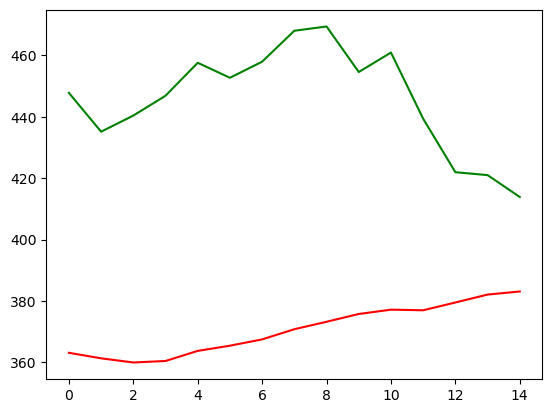

In [18]:
plt.plot(test_results['Predictions'], color = 'red')
plt.plot(test_results['Actual'], color = 'green')

In [19]:
# Calculate RMSE
train_rmse = mean_squared_error(y_train, train_predict, squared=False)

NameError: name 'train_predict' is not defined

In [ ]:
# Define function to take in number of days of predictions
def predict_y(days, data):
    # Normalise data
    data = scaler.fit_transform(data)

    predictions = []
    
    for i in range(days):
        prediction = model.predict(data)
        predictions.append(prediction[0])

        # Remove first day
        data = data[0][1:]

        data = np.concatenate([data, prediction], axis=0)
    
    predictions = scaler.inverse_transform(data)
    predictions = pd.DataFrame(predictions)
    return predictions


In [ ]:
predict_y(DAYS_TO_PRED, X_test)